# Bifurcation diagrams - Figure 9

In [1]:
import CPGNetworkSimulator.tools.py_simulator as nsim
from CPGNetworkSimulator.tools.plt import  plot_2d_bifurcation_diagram
from optparse import OptionParser
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
from yaml_sim import update_sim_from_yaml,yamlload
import os
from datetime import datetime
from classify_gait import classify_gait
import seaborn as sns
import pandas as pd


class suppress_stdout_stderr(object):
    def __enter__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for _ in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors
        self.save_fds = [os.dup(1), os.dup(2)]
        # Assign the null pointers to stdout and stderr
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close all file descriptors
        for fd in self.null_fds + self.save_fds:
            os.close(fd)

def plot_1d_bifurcation_diagram_seg(v,fq,ph,fl_dur,ex_dur,fig_size=(8,10),fqmax=8.0,do_symmetry=True):
    
    cp=sns.color_palette("Paired", 20)
    cp[0]=cp[11]
    cp.pop(7)
    cols = []
    gaits = []
    for i in range(ph.shape[2]):
        df = pd.DataFrame([])
        df['v']=v
        df['LR_h']=  ph[:,0,i]
        df['LR_f']=  ph[:,1,i]
        df['hl']=    ph[:,2,i]
        df['diag']=  ph[:,3,i]
        df['hl_r']=  ph[:,4,i]
        df['diag_2']=ph[:,5,i]
        df['duty_factor']=ex_dur[:,0]/(fl_dur[:,0]+ex_dur[:,i])

        df['duty_factor']=ex_dur[:,0]/(fl_dur[:,0]+ex_dur[:,i])
        classify_gait(df)
        
        col = [cp[k] for k in df.gaits2.cat.codes.values]
        cols.append(col)
        gaits.append(df.gaits2)
    
    ind_ = [[0,-1],[1,-1],[2,4],[4,2],[3,5],[5,3]]
    thr = 45*np.pi/180
    xl= [0.,v[-1]+v[1]-v[0]]
    fig,axs=plt.subplots(9, 1, sharex='all')
    fig.set_size_inches(fig_size)
    for i,c in enumerate(['b','r']):
        ph_ = ph[:,:,i]*2*np.pi
        diffs_=np.sqrt(np.sum(np.angle(np.exp(1j * ph_[1:]) / np.exp(1j * ph_[:-1])) ** 2, axis=1))
        i_sep = np.where(diffs_ > thr)[0]
        i_sep = np.concatenate(([0], i_sep+1, [len(ph_)]))
        segments = []
        for i in range(len(i_sep)-1):
            segments.append((v[i_sep[i]:i_sep[i+1]], ph_[i_sep[i]:i_sep[i+1]]))
        for v_seg,ph_seg in segments:
            for j in range(ph.shape[1]):
                for jj in ind_[j]:
                    if jj==-1:
                        pd_ = -1*ph_seg[:,ind_[j][0]]+np.pi*2
                    else:
                        pd_ = ph_seg[:,jj]
                    
                    pdu = np.unwrap(pd_)
                    if np.nanmax(pdu) < 2*np.pi+0.05:
                        pd_ = pdu
                    i_sep2 = np.where(np.abs(np.diff(pd_)) > np.pi / 2)[0]
                    
                    i_sep2 = np.concatenate(([0], i_sep2+1, [len(pd_)]))
                    for k in range(len(i_sep2)-1):
                        axs[j].plot(v_seg[i_sep2[k]:i_sep2[k+1]],pd_[i_sep2[k]:i_sep2[k+1]]/(np.pi*2), c)
                    if not do_symmetry:
                        break
                
        for j in range(ph.shape[1]):
            
            axs[j].plot(xl,[0.5,0.5],'k--',lw=0.5)
            axs[j].plot(xl,[0.0,0.0],'k--',lw=0.5)
            axs[j].plot(xl,[1.0,1.0],'k--',lw=0.5)
            axs[j].set_xlim(xl)
            axs[j].set_ylim([-0.05, 1.05])
    
    axs[len(ind_)].plot(v,fq[:,0],'b',linewidth=1,)
    axs[len(ind_)].plot(v,fq[:,1],'r',linewidth=1)
    axs[len(ind_)].set_ylim([0.0, fqmax])
    for i in range(2):
        axs[len(ind_) + i + 1].scatter(v, gaits[i].cat.codes.values, c=[cp[k] for k in gaits[i].cat.codes.values],s=2)
    
    sns.despine()
    axs[0].set_ylabel('hLR pd.')
    axs[1].set_ylabel('fLR pd.')
    axs[2].set_ylabel('hl_l pd.')
    axs[3].set_ylabel('hl_r pd.')
    axs[4].set_ylabel('diag pd.')
    axs[5].set_ylabel('diag2 pd.')
    axs[6].set_ylabel('fq')
    axs[7].set_ylabel('gaits up')
    axs[8].set_ylabel('gaits down')
    axs[8].set_xlabel('alpha')
    return fig
    

In [2]:
def run_1d_bifurcation(config_fn,a_range = [0.1, 1.1],steps_per_alpha=1000,its_limit=10):
    config = yamlload(config_fn)
    neurons = ["RGF_NaP_hind_L", "RGF_NaP_hind_R",      # neurons to be read every time step 
                "RGF_NaP_fore_L", "RGF_NaP_fore_R"]
    
    steps = int((a_range[1]-a_range[0])*steps_per_alpha+1)
    
    modelname = config['model_file_name']
    filename = "./models/" + modelname
    case_ = config['case']
    do_symmetry = True
    case_ = 'intact'
    if 'hemi' in config['case']:
        case_ = 'hemisection'
        do_symmetry = False
    if 'cont' in config['case']:
        case_ = 'contusion'
    
    cpg_sim = nsim.simulator(neurons=neurons, filename=filename,dt=0.001,duration=25.) # instantiate simulator
    with suppress_stdout_stderr():
        cpg_sim.initialize_simulator()
        update_sim_from_yaml(config,cpg_sim)
    cpg_sim.its_limit = its_limit
    
    v, fq, ph,fl_dur,ex_dur, _ = cpg_sim.do_1d_bifurcation('alpha', a_range, steps)
    fig = plot_1d_bifurcation_diagram_seg(v, fq, ph, fl_dur,ex_dur,do_symmetry=do_symmetry)
    
    

## Bifurcation diagram of the intact case (Figure 9A1)


updating variables


max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
Iter 10 of 1001*2; It/sec 0.241
Iter 20 of 1001*2; It/sec 1.678
Iter 30 of 1001*2; It/sec 2.004
Iter 40 of 1001*2; It/sec 2.100
Iter 50 of 1001*2; It/sec 2.139
Iter 60 of 1001*2; It/sec 2.082
Iter 70 of 1001*2; It/sec 2.203
Iter 80 of 1001*2; It/sec 2.541
Iter 90 of 1001*2; It/sec 2.697
Iter 100 of 1001*2; It/sec 2.029
Iter 110 of 1001*2; It/sec 1.862
Iter 120 of 1001*2; It/sec 1.977
Iter 130 of 1001*2; It/sec 2.057
Iter 140 of 1001*2; It/sec 2.046
Iter 150 of 1001*2; It/sec 1.971
Iter 160 of 1001*2; It/sec 1.971
Iter 170 of 1001*2; It/sec 2.283
Iter 180 of 1001*2; It/sec 2.388
Iter 190 of 1001*2; It/sec 1.987
Iter 200 of 1001*2; It/sec 1.846
Iter 210 of 1001*2; It/sec 1.853
Iter 220 of 1001*2; It/sec 2.054
Iter 230 of 1001*2; It/sec 2.094
Iter 240 of 1001*2; It/sec 2.179
Iter 250 of 1001*2; It/sec 2.264
It

/var/folders/fz/27jjxdfx3jz5zh_vzsrj6dcm0000gp/T/ipykernel_41386/3164918104.py:80: RuntimeWarning: All-NaN slice encountered
  if np.nanmax(pdu) < 2*np.pi+0.05:


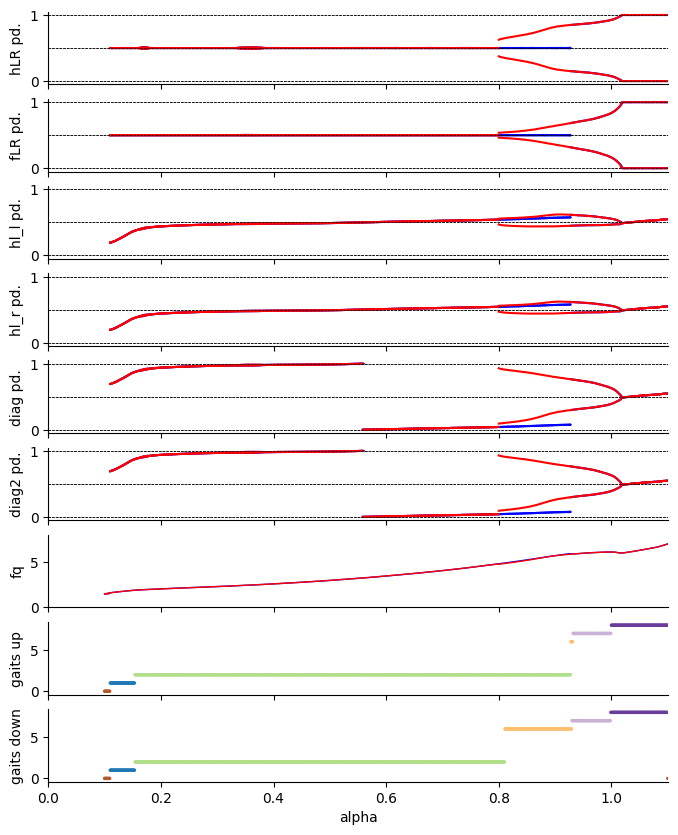

In [3]:
run_1d_bifurcation('./models/config_intact_final.yaml')

## Bifurcation diagram: hemisection (Figure 9A2)


updating variables
group update - name: LPN_hemi_vars , group: LPN_hemi_vars , factor: 0.4
variable name         from     -> to      
aV3diagtoRGF_L       0.6500000 -> 0.2600000
dV0DdiagtoRGF_L      0.7500000 -> 0.3000000
dV0VdiagtoRGF_L      0.2000000 -> 0.0800000
aSh2toRGF_R          0.4000000 -> 0.1600000
dSh2toRGF_R          0.0500000 -> 0.0200000
dLPNitoRGF_R         0.1000000 -> 0.0400000


group update - name: LPN_intact_vars , group: LPN_intact_vars , factor: 1
variable name         from     -> to      
aV3diagtoRGF_R       0.6500000 -> 0.6500000
dV0DdiagtoRGF_R      0.7500000 -> 0.7500000
dV0VdiagtoRGF_R      0.2000000 -> 0.2000000
aSh2toRGF_L          0.4000000 -> 0.4000000
dSh2toRGF_L          0.0500000 -> 0.0500000
dLPNitoRGF_L         0.1000000 -> 0.1000000


group update - name: ipsilesional_hind_RGF_drive , group: RGF_drive_vars , postfix: ['_h_R'] , factor: 0.9
variable name         from     -> to      
drive_to_RGF_h_R     0.0000100 -> 0.0000090


group update - name:

/Users/simon/code/CPGNetworkSimulator/CPGNetworkSimulator/tools/py_simulator.py:326: RuntimeWarning: Mean of empty slice
  print('max its reached')


max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
Iter 920 of 1001*2; It/sec 0.227
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
Iter 930 of 1001*2; It/sec 0.211
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
Iter 940 of 1001*2; It/sec 0.211
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
Iter 950 of 1001*2; It/sec 0.210
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
Iter 960 of 1001*2; It/sec 0.223
max its reached
max its reached
max

/var/folders/fz/27jjxdfx3jz5zh_vzsrj6dcm0000gp/T/ipykernel_41386/3164918104.py:80: RuntimeWarning: All-NaN slice encountered
  if np.nanmax(pdu) < 2*np.pi+0.05:


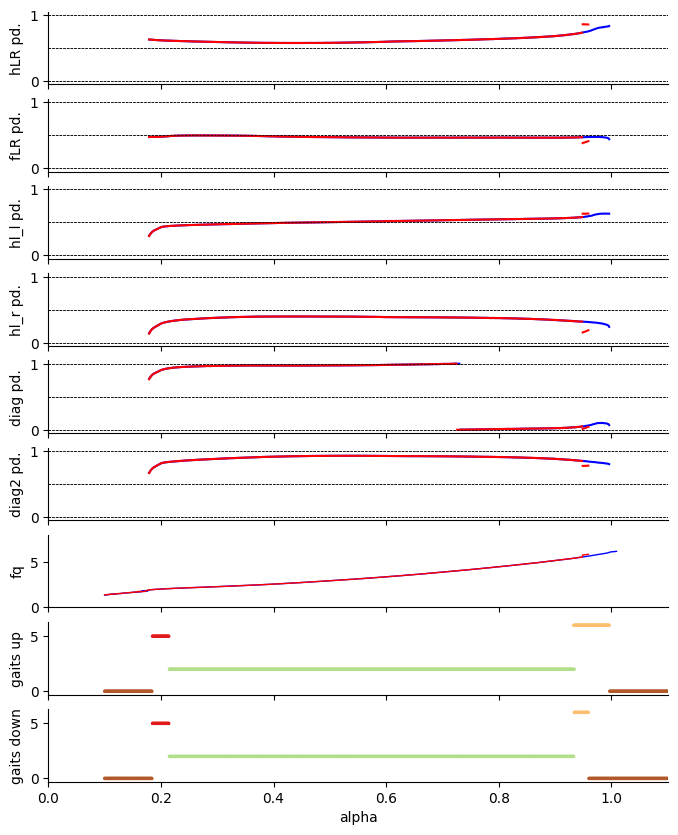

In [4]:
run_1d_bifurcation('./models/config_hemi_final.yaml')

## Bifurcation diagram: only affected LPNs (Figure 9A3)
all other parameters were left at their pre-injury values


updating variables
group update - name: LPN_hemi_vars , group: LPN_hemi_vars , factor: 0.4
variable name         from     -> to      
aV3diagtoRGF_L       0.6500000 -> 0.2600000
dV0DdiagtoRGF_L      0.7500000 -> 0.3000000
dV0VdiagtoRGF_L      0.2000000 -> 0.0800000
aSh2toRGF_R          0.4000000 -> 0.1600000
dSh2toRGF_R          0.0500000 -> 0.0200000
dLPNitoRGF_R         0.1000000 -> 0.0400000




max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
Iter 10 of 1001*2; It/sec 0.242
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
Iter 20 of 1001*2; It/sec 0.224
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
Iter 30 of 1001*2; It/sec 0.220
max its reached
max i

/Users/simon/code/CPGNetworkSimulator/CPGNetworkSimulator/tools/py_simulator.py:326: RuntimeWarning: Mean of empty slice
  print('max its reached')


max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
Iter 920 of 1001*2; It/sec 0.224
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
Iter 930 of 1001*2; It/sec 0.231
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
Iter 940 of 1001*2; It/sec 0.226
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
Iter 950 of 1001*2; It/sec 0.213
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
Iter 960 of 1001*2; It/sec 0.212
max its reached
max its reached
max

/var/folders/fz/27jjxdfx3jz5zh_vzsrj6dcm0000gp/T/ipykernel_41386/3164918104.py:80: RuntimeWarning: All-NaN slice encountered
  if np.nanmax(pdu) < 2*np.pi+0.05:


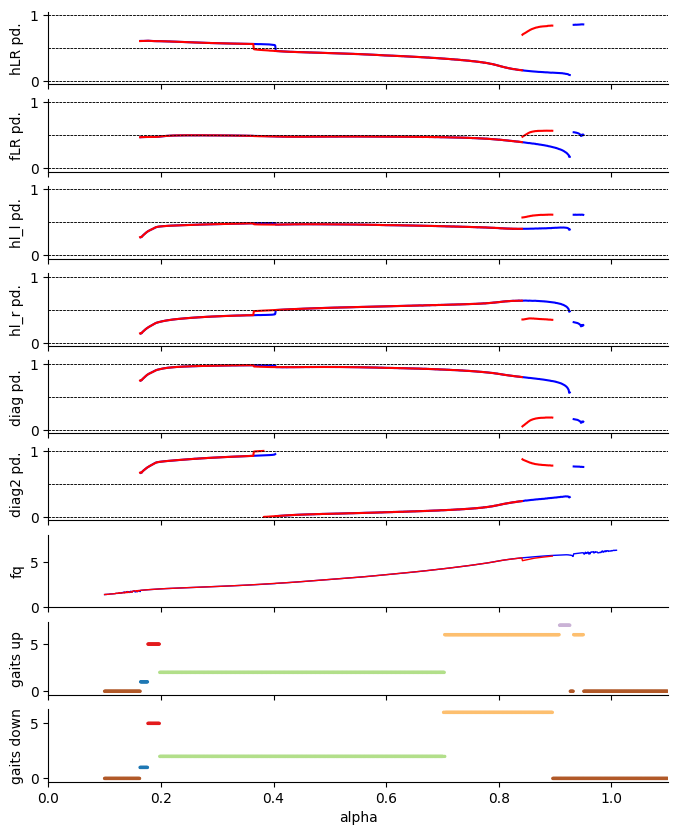

In [5]:
run_1d_bifurcation('./models/config_hemi_final_only_affected_LPNs.yaml')

## Bifurcation diagram: only drive to ipsilesional hind RG reduced to 90% of preinjury (Figure 9A4)
All other parameters were left at their pre-injury values


updating variables
group update - name: ipsilesional_hind_RGF_drive , group: RGF_drive_vars , postfix: ['_h_R'] , factor: 0.9
variable name         from     -> to      
drive_to_RGF_h_R     0.0000100 -> 0.0000090




max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
Iter 10 of 1001*2; It/sec 0.226
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
max its reached
Iter 20 of 1001*2; It/sec 0.226
max its reached
max its reached
max its reached
max its reached
max its reached
Iter 30 of 1001*2; It/sec 0.373
Iter 40 of 1001*2; It/sec 1.913
Iter 50 of 1001*2; It/sec 2.228
Iter 60 of 1001*2; It/sec 2.381
Iter 70 of 1001*2; It/sec 2.548
Iter 80 of 1001*2; It/sec 2.354
Iter 90 of 1001*2; It/sec 2.003
Iter 100 of 1001*2; It/sec 1.958
Iter 110 of 1001*2; It/sec 1.970
Iter 120 of 1001*2; It/sec 1

/var/folders/fz/27jjxdfx3jz5zh_vzsrj6dcm0000gp/T/ipykernel_41386/3164918104.py:80: RuntimeWarning: All-NaN slice encountered
  if np.nanmax(pdu) < 2*np.pi+0.05:


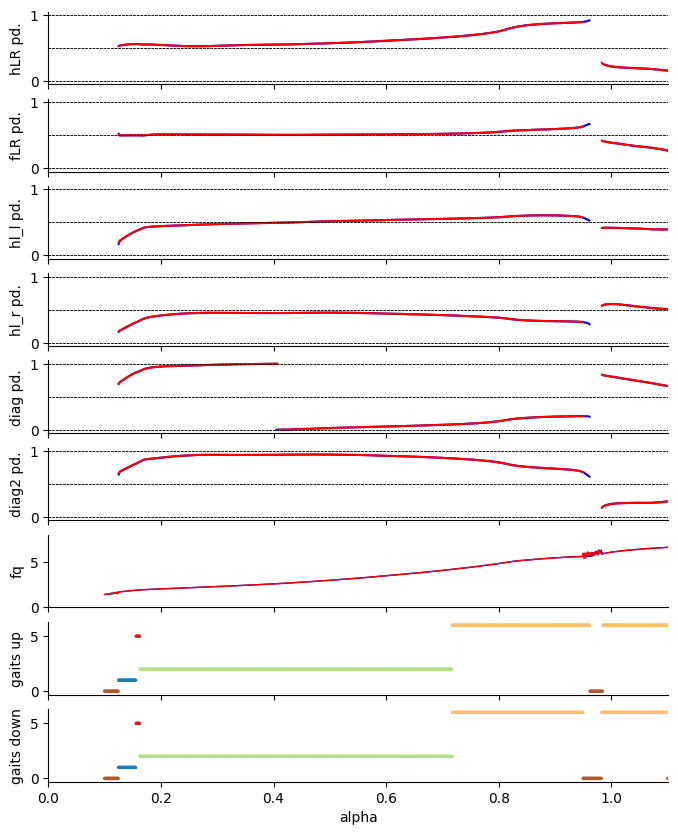

In [6]:
run_1d_bifurcation('./models/config_hemi_final_only_ipsi_hind_RG.yaml')